Medical-style dataset created!
Using device: cpu

Training...

Epoch 1 Loss: 0.7413
Epoch 2 Loss: 0.7249


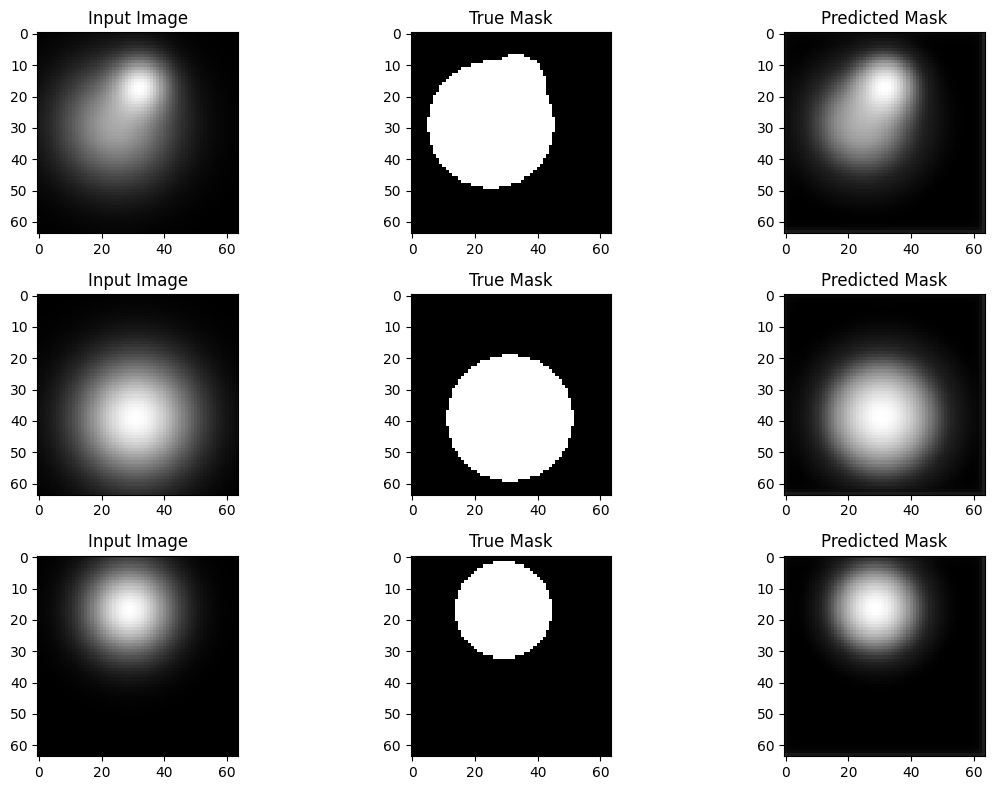

In [2]:
# ======================================
# FAST MEDICAL-STYLE SEGMENTATION DEMO
# Gaussian blobs for synthetic MRI/CT
# ======================================

!pip install torch torchvision matplotlib opencv-python -q

import os, cv2, torch, numpy as np, matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

# -----------------------------
# CREATE SYNTHETIC MEDICAL DATASET
# -----------------------------
os.makedirs("dataset/images", exist_ok=True)
os.makedirs("dataset/masks", exist_ok=True)

IMG_SIZE = 64
N_IMAGES = 10

for i in range(N_IMAGES):
    # create blank image
    img = np.zeros((IMG_SIZE,IMG_SIZE), dtype=np.float32)
    mask = np.zeros_like(img)

    # random number of “tumors”
    n_blobs = np.random.randint(1,3)

    for _ in range(n_blobs):
        # random center
        cx, cy = np.random.randint(16,48), np.random.randint(16,48)
        # random radius
        radius = np.random.randint(5,15)
        # draw Gaussian-like blob
        for x in range(IMG_SIZE):
            for y in range(IMG_SIZE):
                dist = np.sqrt((x-cx)**2 + (y-cy)**2)
                val = np.exp(-((dist**2)/(2*(radius**2))))
                img[x,y] += val
                mask[x,y] = max(mask[x,y], 1 if val>0.3 else 0)

    # normalize to 0-255
    img = (img/img.max()*255).astype(np.uint8)
    mask = (mask*255).astype(np.uint8)

    cv2.imwrite(f"dataset/images/img{i}.png", img)
    cv2.imwrite(f"dataset/masks/img{i}.png", mask)

print("Medical-style dataset created!")

# -----------------------------
# DEVICE
# -----------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

# -----------------------------
# DATASET CLASS
# -----------------------------
class MedicalDataset(Dataset):
    def __init__(self, img_dir, mask_dir):
        self.images = os.listdir(img_dir)
        self.img_dir = img_dir
        self.mask_dir = mask_dir

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        name = self.images[idx]
        img = cv2.imread(os.path.join(self.img_dir,name),0)/255.0
        mask = cv2.imread(os.path.join(self.mask_dir,name),0)/255.0
        img = torch.tensor(img,dtype=torch.float32).unsqueeze(0)
        mask = torch.tensor(mask,dtype=torch.float32).unsqueeze(0)
        return img, mask

# -----------------------------
# LIGHTWEIGHT U-NET
# -----------------------------
class DoubleConv(nn.Module):
    def __init__(self,i,o):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv2d(i,o,3,padding=1), nn.ReLU(),
            nn.Conv2d(o,o,3,padding=1), nn.ReLU()
        )
    def forward(self,x): return self.net(x)

class FastUNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.d1 = DoubleConv(1,16)
        self.d2 = DoubleConv(16,32)
        self.pool = nn.MaxPool2d(2)
        self.u1 = DoubleConv(32+16,16)
        self.up = nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True)
        self.out = nn.Conv2d(16,1,1)

    def forward(self,x):
        c1=self.d1(x)
        p1=self.pool(c1)
        c2=self.d2(p1)
        u1=self.up(c2)
        u1=torch.cat([u1,c1],1)
        c3=self.u1(u1)
        return torch.sigmoid(self.out(c3))

# -----------------------------
# TRAIN
# -----------------------------
dataset = MedicalDataset("dataset/images","dataset/masks")
loader = DataLoader(dataset,batch_size=2,shuffle=True)

model = FastUNet().to(device)
opt = torch.optim.Adam(model.parameters(),1e-3)
loss_fn = nn.BCELoss()

print("\nTraining...\n")
for epoch in range(2):
    total=0
    for img,mask in loader:
        img,mask = img.to(device), mask.to(device)
        pred = model(img)
        loss = loss_fn(pred,mask)
        opt.zero_grad()
        loss.backward()
        opt.step()
        total+=loss.item()
    print(f"Epoch {epoch+1} Loss: {total/len(loader):.4f}")

# -----------------------------
# SHOW MULTIPLE PREDICTIONS
# -----------------------------
model.eval()
plt.figure(figsize=(12,8))

for i in range(3):
    img,mask = dataset[i]
    with torch.no_grad():
        pred = model(img.unsqueeze(0).to(device))[0][0].cpu()
    plt.subplot(3,3,i*3+1)
    plt.title("Input Image"); plt.imshow(img[0],cmap="gray")
    plt.subplot(3,3,i*3+2)
    plt.title("True Mask"); plt.imshow(mask[0],cmap="gray")
    plt.subplot(3,3,i*3+3)
    plt.title("Predicted Mask"); plt.imshow(pred,cmap="gray")

plt.tight_layout()
plt.show()
